In [ ]:
!nvidia-smi

Sun Sep  6 15:15:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -qq arff2pandas

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq -U pandas

     |████████████████████████████████| 10.5MB 6.3MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.1 which is incompatible.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split

import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline
sns.set_style("darkgrid")
sns.set(color_codes=True)
plt.style.use('seaborn-dark')
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Data

In [6]:
telemetry = pd.read_csv('/content/drive/My Drive/Temp/PdM_telemetry.csv', error_bad_lines=False, index_col=0, parse_dates=True)
failures = pd.read_csv('/content/drive/My Drive/Temp/PdM_failures.csv', error_bad_lines=False, index_col=0, parse_dates=True)

b'Skipping line 92490: expected 6 fields, saw 9\n'


In [7]:
df = telemetry['vibration']
ids = telemetry['machineID']

train_df = df[ids <= 75]
val_df = df[(ids > 75) & (ids <= 90)]
test_df = df[ids > 90]

In [8]:
SEQ_LEN = 8760

In [9]:
def data_preprocess(data, i, feature):
  cropped_data = data[data['machineID'] == i][feature].iloc[:SEQ_LEN]
  numpys_data = np.array(cropped_data)
  torches_data = torch.tensor(numpys_data).float()

  return torches_data

In [10]:
def create_dataset(df, feature):
    dataset = np.array([])
    list_dataset = [ data_preprocess(df, i, feature) for i in range(1, 101) ]
    train_df = list_dataset[:76]
    val_df = list_dataset[76:91]
    test_df = list_dataset[91:]
    return train_df, val_df, test_df

In [16]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,170.774119,446.591205,100.841515,40.383648
std,30.450409,15.507488,52.701718,11.028763,5.366198
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,18.000000,160.298184,412.278255,93.492369,36.778303
50%,45.000000,170.597611,447.555368,100.414332,40.237433
75%,73.000000,181.006196,482.154486,107.535244,43.781329
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [17]:
norm_telemetry = telemetry
norm_telemetry['vibration'] = norm_telemetry['vibration'] / 80
norm_telemetry['volt'] = norm_telemetry['volt'] / 256
norm_telemetry['rotate'] = norm_telemetry['rotate'] / 700
norm_telemetry['pressure'] = norm_telemetry['pressure'] / 190

In [18]:
norm_telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,0.667086,0.637987,0.530745,0.504796
std,30.450409,0.060576,0.075288,0.058046,0.067077
min,1.000000,0.380209,0.197760,0.269669,0.185963
25%,18.000000,0.626165,0.588969,0.492065,0.459729
50%,45.000000,0.666397,0.639365,0.528496,0.502968
75%,73.000000,0.707055,0.688792,0.565975,0.547267
max,100.000000,0.996581,0.992887,0.978695,0.959888


In [19]:
X_train, X_val, X_test = create_dataset(norm_telemetry, 'vibration')

# Draw

In [24]:
d1 = norm_telemetry[telemetry['machineID'] == 1]
d2 = failures[failures['machineID'] == 1]
d2['one'] = 0

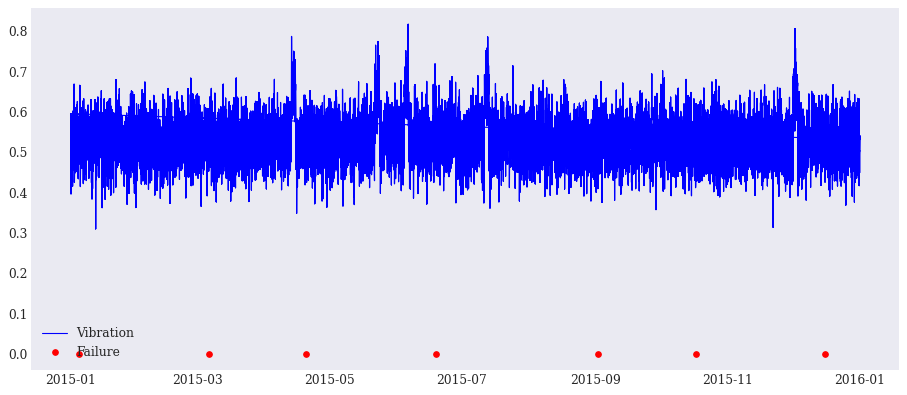

In [37]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(d1['pressure'],  label='Vibration', color='blue', animated=True, linewidth=1)
ax.plot(d2['one'], label='Failure', color='red', marker='o', markersize=5, linestyle='none')
plt.legend(loc='lower left')
plt.show()

# Model

In [26]:
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [27]:
class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)

In [28]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [32]:
model = RecurrentAutoencoder(SEQ_LEN, 1, 128)
model = model.to(device)

In [33]:
def train(model, train_dataset, val_dataset, n_epochs, log_interval=5):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  print('lets start...')
  
  for epoch in range(1, n_epochs + 1):
    print('train...')
    model = model.train()

    train_losses = []
    for idx, seq_true in enumerate(train_dataset):
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      if idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, idx, len(train_dataset),
            100. * idx / len(train_dataset), loss.item()))
        print(seq_pred.shape)

    print('some more...')

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    print('and more...')

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [34]:
new_model, history = train(model, X_train, X_val, n_epochs=50)

lets start...
train...
Train Epoch: 1 [0/76 (0%)]	Loss: 38646616.000000
torch.Size([8760, 1])
Train Epoch: 1 [5/76 (7%)]	Loss: 10181998.000000
torch.Size([8760, 1])


KeyboardInterrupt: ignored